In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

from astropy import units as u
from astropy import constants as c
from astropy.io import ascii
from matplotlib.ticker import FormatStrFormatter

import ipywidgets as widgets

%matplotlib inline

In [2]:
dark_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white',
                'axes.facecolor': '#384151',
                'axes.edgecolor': 'white'}

sns.set_style(dark_style)

In [3]:
G = (1 * c.G).cgs.value
M = (1 * u.solMass).cgs.value
au = (1 * u.AU).cgs.value

In [4]:
def sho_func(t, uin): # calculates derivatives for RK4
    # position and velocity
    r = uin[:2]
    v = uin[2:]
    
    # distance of point mass from each M
    d = np.linalg.norm(0 - r)

    # calulating accelerations
    g = (G*M/d**3) * (0 - r)
    
    derivs = np.ndarray(4)
    derivs[:2] = v
    derivs[2:] = g
    
    return derivs

In [5]:
def sho_RK4(t, u_old, dt):
    K1 = sho_func(t, u_old)
    K2 = sho_func(t + dt/2, u_old + K1*dt/2)
    K3 = sho_func(t + dt/2, u_old + K2*dt/2)
    K4 = sho_func(t + dt, u_old + K3*dt)
    
    u_new = u_old + (dt/6)*(K1 + 2*(K2 + K3) + K4)
    return u_new

In [10]:
mx = np.arange(10)
mx

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
mx[::3]

array([0, 3, 6, 9])

In [22]:
def orb_plot(x_pos, x_vel, y_vel, T, dt_int):
    # Initial conditions
    x = -x_pos*au
    y = 0
    a0 = np.sqrt(x**2 + y**2)
    v_circ = np.sqrt(G * M / a0)

    vx = x_vel*v_circ
    vy = -y_vel*v_circ
    T0 = (1 * u.year).cgs.value

    tmax  =  T*T0
    dt = tmax/dt_int

    pos_0 = np.array([x, y])
    vel_0 = np.array([vx, vy])

    uold = np.zeros(4)
    uold[:2] = pos_0
    uold[2:] = vel_0

    x = []
    y = []
    vx = []
    vy = []
    
    x.append(uold[0])
    y.append(uold[1])
    vx.append(uold[2])
    vy.append(uold[3])

    # Integrate orbit
    for t in np.arange(0, tmax+dt, dt):
        unew = sho_RK4(t, uold, dt)

        x.append(unew[0])
        y.append(unew[1])
        vx.append(unew[2])
        vy.append(unew[3])

        uold = unew # step forward

    # write to file
    ascii.write([x,y,vx,vy], './orb.dat', names=['x', 'y', 'vx', 'vy'],
               overwrite=True)
    
    x = np.array(x) / au
    y = np.array(y) / au

    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect(aspect='equal')
    lim = 2.5
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # plot trajectory
    ax.plot(x, y, color='orange')
    ax.plot(x[::10], y[::10], 'w.') # for visualizing dt spacing
    
    # overplot circular orbit
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), ls='--', color='cyan')
    
    # plot starting and ending points
    plt.plot(x[0], y[0], 'go', ms=10)
    plt.plot(x[-1], y[-1], 'ro', ms=10)
    
    fig.tight_layout()
    plt.show()

In [23]:
sns.set_style(dark_style)
sns.set_color_codes('deep')

box_layout = widgets.Layout(
    display='inline-flex',
    flex_flow='row wrap',
    justify_content='flex-start'
)

items = [
    widgets.FloatSlider(value=1, min=0.1, max=2, step=0.01, 
                        description='$-r_x / 1$ $AU$'),
    widgets.FloatSlider(value=0, min=-2, max=2, step=0.01, 
                        description='$v_x / v_c$'),
    widgets.FloatSlider(value=1, min=-2, max=2, step=0.01, 
                        description='$-v_y / v_c$'),
    widgets.FloatSlider(value=1, min=0.1, max=5, step=0.01, 
                        description='$T$ / $1\ year$'),
    widgets.FloatSlider(value=(1E3+1E2)/2, min=1E2, max=1E3, step=1E1, 
                        description='$dt\ \ (T\ / \ dt)$')
        ]

w = widgets.interactive(orb_plot, x_pos=items[0], x_vel=items[1], 
                        y_vel=items[2], T = items[3], dt_int = items[4])

w.layout = box_layout
w

# Taking a look at the data

In [24]:
t = ascii.read('./orb.dat')
t

x,y,vx,vy
float64,float64,float64,float64
-1.495978707e+13,0.0,2204067.1954,-2889115.10748
-1.48965509193e+13,-82571813220.6,2221087.2442,-2889067.93664
-1.48328262718e+13,-165140912944.0,2238251.38063,-2888924.81897
-1.47686089901e+13,-247704522058.0,2255560.95982,-2888683.3017
-1.4703894898e+13,-330259792478.0,2273017.33839,-2888340.87082
-1.46386797804e+13,-412803803376.0,2290621.87364,-2887894.94963
-1.45729593836e+13,-495333559364.0,2308375.92275,-2887342.89713
-1.45067294151e+13,-577845988637.0,2326280.84184,-2886682.00651
-1.44399855434e+13,-660337941069.0,2344337.98504,-2885909.50351


In [25]:
dist = np.sqrt(t['x']**2 + t['y']**2) # distance

speed = np.sqrt(t['vx']**2 + t['vy']**2) # speed
speed_0 = np.sqrt(t['vx'][0]**2 + t['vy'][0]**2)

spec_E = 0.5*speed**2 - G*M/dist # specific energy
spec_E0 = 0.5*speed[0]**2 - G*M/dist[0]

spec_L = []
for i in range(len(t['x'])):
    r = np.array([t['x'][i], t['y'][i], 0])
    v = np.array([t['vx'][i], t['vy'][i], 0])
    spec_L_i = np.linalg.norm(np.cross(r, v))
    spec_L.append(spec_L_i)
r0 = np.array([t['x'][0], t['y'][0], 0])
v0 = np.array([t['vx'][0], t['vy'][0], 0])
spec_L0 = np.linalg.norm(np.cross(r0, v0))

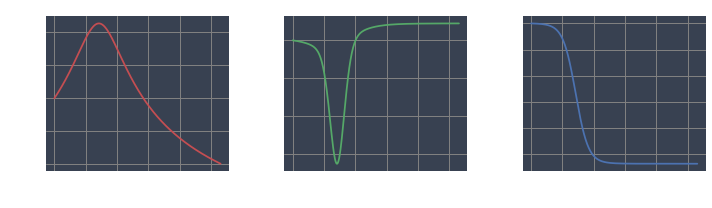

In [31]:
dark_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white',
                'axes.facecolor': '#384151',
                'grid.color' : 'grey'
              }

sns.set_style(dark_style)
fig, ax = plt.subplots(1, 3, figsize=(10,3))

# speed
ax[0].plot(speed / speed_0, 'r')
ax[0].set_xlabel('step')
ax[0].set_ylabel('$v/v_0$')

# specific energy
ax[1].plot(spec_E / spec_E0, 'g')
ax[1].set_xlabel('step')
ax[1].set_ylabel('$E/E_0$')

# specific angular momentum
ax[2].plot(spec_L / spec_L0, 'b')
ax[2].set_xlabel('step')
ax[2].set_ylabel('$L/L_0$')
fig.tight_layout()

In [91]:
from matplotlib import animation, rc
from IPython.display import HTML

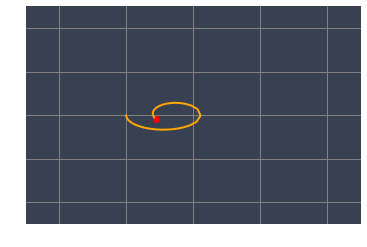

In [181]:
fig, ax = plt.subplots()

lim = 2.5
ax.set_xlim(( -lim, lim))
ax.set_ylim((-lim, lim))

line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = t['x'][i] / au
    y = t['y'][i] / au
    line.set_data(x, y)
    line.set_marker('o')
    line.set_color('red')
    
    line2.set_data(t['x'][:i] / au, t['y'][:i] / au)
    line2.set_color('orange')
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
N = len(t['x'])
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int(N/2), interval=10, blit=True)
HTML(anim.to_html5_video())